In [1]:
import timm
import torch
import wandb
import fastai
import dill
from sklearn.utils.class_weight import compute_class_weight
from fastai.callback.wandb import WandbCallback
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.text.core import RegexLabeller
from fastai.vision.utils import get_image_files
from fastai.data.block import DataBlock
from fastai.data.core import *
from fastai.tabular.all import *
os.environ['WANDB_NOTEBOOK_NAME'] = 'Parameter_Optimization_Sweep.ipynb'

In [2]:
# define configs and parameters
# define static parameters
meta_config = SimpleNamespace(
    dataset_path = r"/blue/hulcr/gmarais/Beetle_data/selected_images/train_data",
    img_size=224,
    seed=42,
    project="Ambrosia_Symbiosis",
    # group="Beetle_classifier",
    # job_type="parameter_optimization"
    )

# define parameter optimization config
sweep_config = {
    'name': 'Beetle_Classifier_Sweep',
    'project':meta_config.project,
    'method': 'bayes',
    'run_cap':10,
    'metric': {
        'goal': 'minimize', 
        'name': 'validation_loss'
        },
    # 'early_terminate':{
    #     'type': 'hyperband',
    #     'min_iter': 1,
    #     'max_iter': 100,
    #     'eta': 3,
    #     's': 2
    # },
    'parameters': {
        'pretrained':{'values': [True, False]},
        'model_name':{'values': ["maxvit_rmlp_small_rw_224.sw_in1k"]},
        'batch_size': {'values': [128, 64, 256]},
        'epochs': {'values': [2, 5, 3]},
     }
}

In [3]:
# define functions required for sweep
def get_images(dataset_path, batch_size, img_size, seed, subfolders=('train','valid')):
    "The beetles dataset"
    files = get_image_files(path=dataset_path, recurse=True, folders=subfolders)
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       splitter = GrandparentSplitter(train_name=subfolders[0], valid_name=subfolders[1]),
                       get_y = parent_label,
                       item_tfms = Resize(img_size, ResizeMethod.Pad, pad_mode='zeros'))
    dls = dblock.dataloaders(dataset_path, bs = batch_size)
    return dls

def train(meta_config):
    "Train the model using the supplied configs"
    run = wandb.init(project=meta_config.project) # , job_type=meta_config.job_type, group =meta_config.group, 
    dls = get_images(dataset_path=meta_config.dataset_path, img_size=meta_config.img_size, seed=meta_config.seed, batch_size=wandb.config.batch_size)
    labels = np.array([str(x).split('/')[-2] for x in dls.items])
    classes = np.unique(labels)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    class_weights = {c: w for c, w in zip(classes, weights)}
    weights = tensor([class_weights[c] for c in dls.vocab]).to(dls.device)
    cbs = [MixedPrecision(), ShowGraphCallback(), SaveModelCallback(), WandbCallback(log='all')] 
    learn = vision_learner(dls, 
                           wandb.config.model_name,
                           loss_func=LabelSmoothingCrossEntropy(weight=weights),
                           metrics=[error_rate, 
                                    accuracy, 
                                    top_k_accuracy], 
                           cbs=cbs, 
                           pretrained=wandb.config.pretrained)
    learn.fine_tune(wandb.config.epochs)
    run.finish()
    
# Prepare training wrapper based on configs
def train_wrapper():
    train(meta_config = meta_config)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


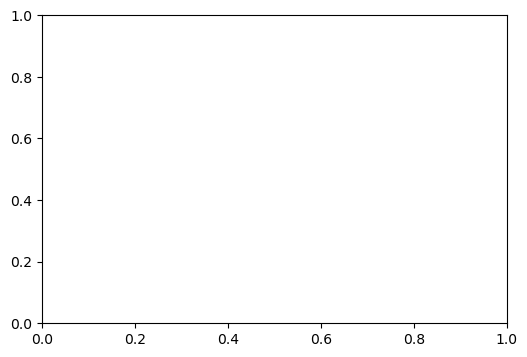

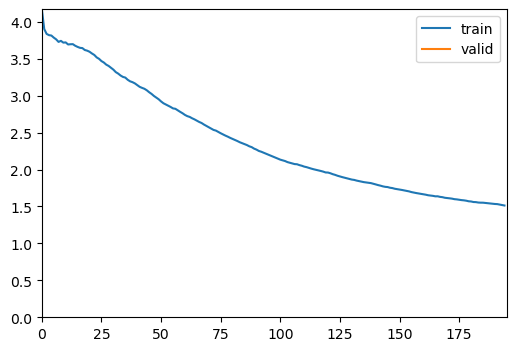

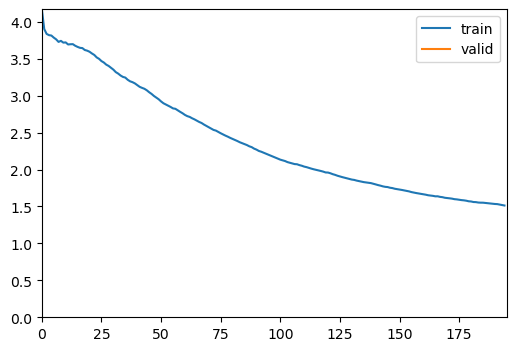

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.513338,1.200015,0.259408,0.740592,0.985135,01:35


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


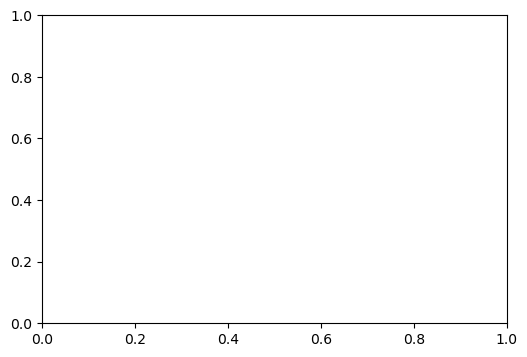

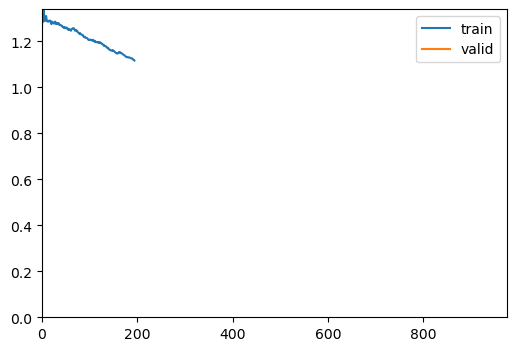

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53


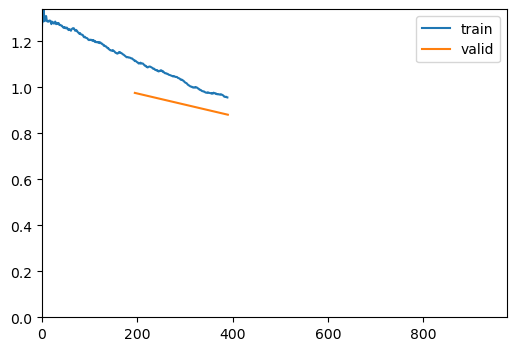

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53


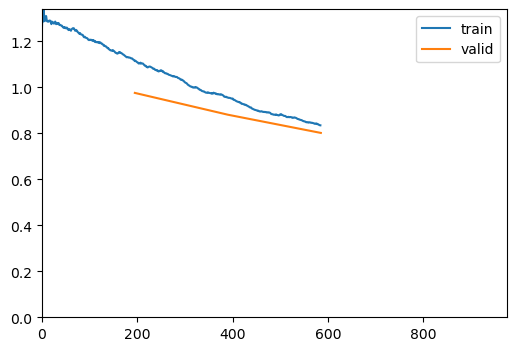

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52


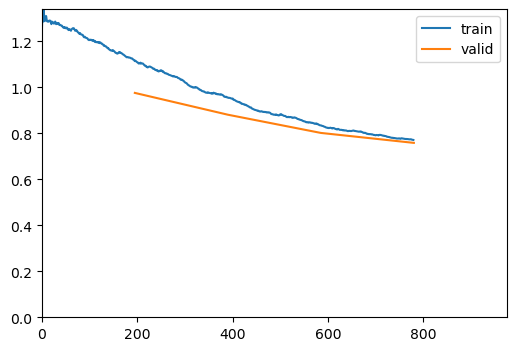

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53


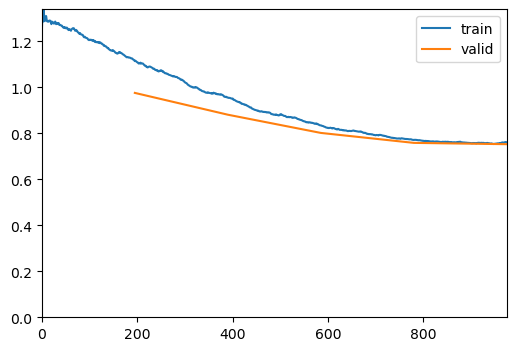

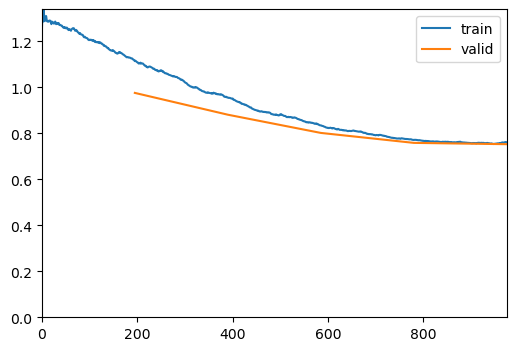

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.116479,0.975714,0.150261,0.849739,0.995982,01:53
1,0.955871,0.880887,0.114102,0.885898,0.996786,01:53
2,0.834773,0.801666,0.079014,0.920986,0.998661,01:52
3,0.771155,0.758388,0.059194,0.940806,0.999196,01:53
4,0.761325,0.752675,0.057988,0.942012,0.999330,01:52


In [4]:
# Run sweep    
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train_wrapper)